## [Practice 4] Road Sign Detection
* 0. 실습 환경 설정
* 1. 데이터 준비하기
    * 1-1. Pascal VOC Format to YOLO Format
    * 1-2. 데이터 전처리하기
    * 1-3. Config file 만들기
* 2. Training
* 3. Testing
* 4. Inference
* 5. TensorRT 변환
    * 5-1. Export
    * 5-2. 결과 비교하기

### 0. 실습 환경 설정
* 가상환경명 : yolov8
* Python 버전 : python 3.8
* 설치 목록
    * !pip install ultralytics
    * !pip install opencv-python
    * !pip install matplotlib

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 124.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [ ]:
import ultralytics
ultralytics.checks()

Ultralytics 8.3.143 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.3/112.6 GB disk)


### 1. 데이터 준비하기
### 1-1. Pascal VOC Format to YOLO Format

* TODO : 데이터셋 다운로드 [링크](https://www.kaggle.com/datasets/andrewmvd/road-sign-detection)
* TODO : `road_sign_root`에 위 데이터셋 담겨있는 폴더 경로 넣어주기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import xml.etree.ElementTree as ET
import glob
import os
import json
from tqdm import tqdm

In [ ]:
def xml_to_yolo_bbox(bbox, w, h):
    # xmin, ymin, xmax, ymax
    x_center = ((bbox[2] + bbox[0]) / 2) / w
    y_center = ((bbox[3] + bbox[1]) / 2) / h
    width = (bbox[2] - bbox[0]) / w
    height = (bbox[3] - bbox[1]) / h
    return [x_center, y_center, width, height]

In [ ]:
road_sign_root = '/content/drive/MyDrive/Object_Detection/Road_Sign'
annot_path = os.path.join(road_sign_root,"annotations")
img_path = os.path.join(road_sign_root,"images")
label_path = os.path.join(road_sign_root,"labels")

if not os.path.exists(label_path):
    os.makedirs(label_path)

In [ ]:
classes = []

files = glob.glob(os.path.join(annot_path, '*.xml'))
for fil in tqdm(files):

    basename = os.path.basename(fil)
    filename = os.path.splitext(basename)[0]

    result = []

    tree = ET.parse(fil)
    root = tree.getroot()
    width = int(root.find("size").find("width").text)
    height = int(root.find("size").find("height").text)
    for obj in root.findall('object'):
        label = obj.find("name").text
        if label not in classes:
            classes.append(label)
        index = classes.index(label)
        pil_bbox = [int(x.text) for x in obj.find("bndbox")]
        yolo_bbox = xml_to_yolo_bbox(pil_bbox, width, height)
        bbox_string = " ".join([str(x) for x in yolo_bbox])
        result.append(f"{index} {bbox_string}")
    if result:
        with open(os.path.join(label_path, f"{filename}.txt"), "w", encoding="utf-8") as f:
            f.write("\n".join(result))

100%|██████████| 877/877 [00:26<00:00, 32.56it/s] 


### 1-2. 데이터 전처리하기

* TODO : 경로이동 (데이터셋 폴더의 상위폴더로 이동)
* TODO : `road_sign_path` 에  데이터셋 폴더 넣어주기

In [ ]:
cd /content/drive/MyDrive/Object_Detection/Road_Sign

/content/drive/MyDrive/Object_Detection/Road_Sign


In [ ]:
import os
import random
from shutil import copyfile, rmtree

road_sign_path = '/content/drive/MyDrive/Object_Detection/Road_Sign/'
label_ = '.txt'
img_ = '.png'

# 저장 경로 만들기
folder_list = ['road_sign_detection/train', 'road_sign_detection/val', 'road_sign_detection/train/images', \
                'road_sign_detection/train/labels', 'road_sign_detection/val/images', 'road_sign_detection/val/labels']
for folder in folder_list:
    if not os.path.exists(folder):
        os.makedirs(folder)

In [ ]:
file_list = os.listdir(os.path.join(road_sign_path, 'images'))

random.shuffle(file_list)

test_ratio = 0.1
test_list = file_list[:int(len(file_list)*test_ratio)]
train_list = file_list[int(len(file_list)*test_ratio):]

print(f"train의 개수 : {len(train_list)}, test의 개수 : {len(test_list)}")

dataset_base_path = os.path.join(road_sign_path, 'road_sign_detection')

for i in test_list:
  f_name = os.path.splitext(i)[0]
  copyfile(os.path.join(road_sign_path, 'images', (f_name+img_)), os.path.join(dataset_base_path, 'val/images', (f_name+img_)))
  copyfile(os.path.join(road_sign_path, 'labels', (f_name+label_)), os.path.join(dataset_base_path, 'val/labels', (f_name+label_)))
for i in train_list:
  f_name = os.path.splitext(i)[0]
  copyfile(os.path.join(road_sign_path, 'images', (f_name+img_)), os.path.join(dataset_base_path, 'train/images', (f_name+img_)))
  copyfile(os.path.join(road_sign_path, 'labels', (f_name+label_)), os.path.join(dataset_base_path, 'train/labels', (f_name+label_)))

train의 개수 : 790, test의 개수 : 87


### 1-3. Config file 만들기

* TODO : project_road_sign_detection 폴더 만들기
* TODO : 위치 변경 (project_road_sign_detection 폴더로)
* TODO : data['train'], data['val'], data['test'] 입력해주기
    * ${road_sign_detection_dataset root}/train'
    * ${road_sign_detection_dataset root}/val'
    * ${road_sign_detection_dataset root}/val'

In [ ]:
cd /content/drive/MyDrive/Object_Detection/Road_Sign/project_road_sign_detection

/content/drive/MyDrive/Object_Detection/Road_Sign/project_road_sign_detection


In [ ]:
import yaml
data =dict()

data['train'] = '/content/drive/MyDrive/Object_Detection/Road_Sign/road_sign_detection/train'
data['val'] = '/content/drive/MyDrive/Object_Detection/Road_Sign/road_sign_detection/val'
data['test'] = '/content/drive/MyDrive/Object_Detection/Road_Sign/road_sign_detection/val'

data['nc'] = 4
data['names'] =['Trafic_light','Speedlimit', 'Crosswalk','Stop']

with open('road_sign.yaml', 'w') as f:
	yaml.dump(data, f)

### 2. Training

* TODO : 위치 변경 (project_road_sign_detection 폴더로)

In [ ]:
cd /content/drive/MyDrive/Object_Detection/Road_Sign/project_road_sign_detection

/content/drive/MyDrive/Object_Detection/Road_Sign/project_road_sign_detection


In [ ]:
from ultralytics import YOLO
model = YOLO('yolo11n.yaml')
results = model.train(data ='road_sign.yaml', epochs = 100, batch=32,device = 0  , patience=30, name='road_sign_s')

Ultralytics 8.3.143 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=road_sign.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=road_sign_s2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=30, perspective=0.0, plots=True, pose=12.0, pretrained=True, p

train: Scanning /content/drive/MyDrive/Object_Detection/Road_Sign/road_sign_detection/train/labels.cache... 790 images, 0 backgrounds, 0 corrupt: 100%|██████████| 790/790 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 1.7±2.5 ms, read: 70.0±33.6 MB/s, size: 239.5 KB)


val: Scanning /content/drive/MyDrive/Object_Detection/Road_Sign/road_sign_detection/val/labels.cache... 87 images, 1 backgrounds, 0 corrupt: 100%|██████████| 88/88 [00:00<?, ?it/s]


Plotting labels to runs/detect/road_sign_s2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/road_sign_s2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      4.39G      3.609      5.778      4.311         59        640: 100%|██████████| 25/25 [00:23<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.21s/it]

                   all         88        122   0.000122     0.0571    6.7e-05   2.52e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      5.15G      3.311      5.092      3.856         64        640: 100%|██████████| 25/25 [00:19<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.66it/s]

                   all         88        122   8.16e-05     0.0542   4.68e-05   2.31e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      5.15G      2.995      4.479      3.302         45        640: 100%|██████████| 25/25 [00:19<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]

                   all         88        122   0.000101     0.0542   6.33e-05   2.72e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      5.15G      2.568      3.674      2.852         60        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.65it/s]

                   all         88        122   0.000174     0.0958     0.0414     0.0124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      5.15G      2.295      2.958      2.533         64        640: 100%|██████████| 25/25 [00:20<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.36it/s]

                   all         88        122       0.72      0.141      0.159     0.0754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      5.15G      1.968      2.403      2.255         53        640: 100%|██████████| 25/25 [00:18<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.48it/s]

                   all         88        122      0.956      0.313      0.437      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      5.15G      1.741      2.022      2.021         57        640: 100%|██████████| 25/25 [00:19<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all         88        122      0.823      0.326      0.434      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      5.16G      1.618      1.848      1.901         53        640: 100%|██████████| 25/25 [00:18<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.46it/s]

                   all         88        122      0.894      0.415       0.51      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      5.18G      1.457      1.612      1.778         66        640: 100%|██████████| 25/25 [00:19<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all         88        122      0.853      0.505      0.587      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      5.19G      1.446      1.584      1.744         57        640: 100%|██████████| 25/25 [00:18<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]

                   all         88        122      0.879      0.477      0.573      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      5.19G      1.375      1.487      1.664         50        640: 100%|██████████| 25/25 [00:18<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]

                   all         88        122       0.87      0.495      0.573      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      5.19G      1.255      1.366      1.575         48        640: 100%|██████████| 25/25 [00:19<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.16it/s]

                   all         88        122       0.96      0.597      0.662      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      5.19G      1.221      1.263      1.551         64        640: 100%|██████████| 25/25 [00:19<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]

                   all         88        122      0.883      0.506      0.574      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      5.21G      1.206      1.208      1.516         74        640: 100%|██████████| 25/25 [00:19<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.36it/s]

                   all         88        122       0.82      0.675      0.718      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      5.21G      1.139      1.112      1.461         64        640: 100%|██████████| 25/25 [00:18<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.65it/s]

                   all         88        122      0.845      0.621      0.671      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      5.21G      1.166      1.147       1.48         52        640: 100%|██████████| 25/25 [00:19<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.52it/s]

                   all         88        122      0.712      0.606      0.641      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      5.21G      1.103      1.068       1.42         53        640: 100%|██████████| 25/25 [00:18<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.66it/s]

                   all         88        122      0.674      0.531      0.646      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      5.21G      1.053      1.021       1.41         49        640: 100%|██████████| 25/25 [00:20<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]

                   all         88        122       0.89       0.68      0.709      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      5.21G      1.074      1.024       1.39         68        640: 100%|██████████| 25/25 [00:20<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.16it/s]

                   all         88        122      0.841      0.643      0.672      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      5.21G      1.034     0.9813       1.36         56        640: 100%|██████████| 25/25 [00:19<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.66it/s]

                   all         88        122      0.839      0.674      0.737       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      5.21G      0.984     0.9302      1.309         59        640: 100%|██████████| 25/25 [00:21<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]

                   all         88        122      0.678      0.757      0.718      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      5.21G      1.012     0.9157      1.337         65        640: 100%|██████████| 25/25 [00:17<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]

                   all         88        122      0.768      0.754      0.734      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      5.21G      1.033     0.9361      1.342         40        640: 100%|██████████| 25/25 [00:18<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]

                   all         88        122      0.818      0.734      0.754      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      5.21G     0.9599     0.8608      1.286         59        640: 100%|██████████| 25/25 [00:18<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]

                   all         88        122      0.869      0.662      0.708       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      5.21G     0.9662     0.8755      1.289         60        640: 100%|██████████| 25/25 [00:18<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]

                   all         88        122      0.941      0.696      0.785      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      5.21G     0.9413     0.8554       1.29         60        640: 100%|██████████| 25/25 [00:22<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]

                   all         88        122      0.812      0.647      0.666      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      5.21G     0.9448     0.8304      1.259         56        640: 100%|██████████| 25/25 [00:19<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.37it/s]

                   all         88        122      0.843      0.755      0.762      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      5.21G     0.8896     0.7717      1.223         54        640: 100%|██████████| 25/25 [00:19<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]

                   all         88        122      0.798      0.737      0.758      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      5.21G      0.929     0.8351      1.276         37        640: 100%|██████████| 25/25 [00:18<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]

                   all         88        122      0.847      0.755      0.789      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      5.21G     0.9444     0.8146      1.233         48        640: 100%|██████████| 25/25 [00:19<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.52it/s]

                   all         88        122       0.92      0.706      0.774      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      5.21G     0.8718     0.7457      1.219         55        640: 100%|██████████| 25/25 [00:18<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.03it/s]

                   all         88        122       0.85      0.778        0.8      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      5.21G     0.8843     0.7697      1.224         55        640: 100%|██████████| 25/25 [00:17<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.40it/s]

                   all         88        122      0.844      0.689      0.754      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      5.21G     0.8762     0.7183      1.205         59        640: 100%|██████████| 25/25 [00:19<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]

                   all         88        122      0.898      0.793      0.812      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      5.21G     0.8949     0.7579      1.221         51        640: 100%|██████████| 25/25 [00:17<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]

                   all         88        122      0.856      0.703      0.759      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      5.21G     0.8546     0.7219      1.194         52        640: 100%|██████████| 25/25 [00:18<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all         88        122      0.864      0.717       0.81      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      5.21G     0.8878     0.7439      1.218         54        640: 100%|██████████| 25/25 [00:18<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.41it/s]

                   all         88        122      0.897      0.735      0.808      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      5.21G     0.8648     0.7151      1.194         52        640: 100%|██████████| 25/25 [00:19<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.41it/s]

                   all         88        122      0.858      0.802      0.836      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      5.21G     0.8491     0.7066      1.194         43        640: 100%|██████████| 25/25 [00:18<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]

                   all         88        122      0.883      0.663      0.767      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      5.21G      0.818     0.6981      1.186         58        640: 100%|██████████| 25/25 [00:19<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.65it/s]

                   all         88        122      0.951      0.734      0.811      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      5.21G     0.8179     0.6703       1.16         53        640: 100%|██████████| 25/25 [00:18<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.50it/s]

                   all         88        122      0.908       0.75      0.791      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      5.21G     0.8269     0.6799      1.178         48        640: 100%|██████████| 25/25 [00:19<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.39it/s]

                   all         88        122      0.843      0.793      0.797      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      5.21G     0.8372     0.6856      1.184         43        640: 100%|██████████| 25/25 [00:17<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]

                   all         88        122      0.885      0.759      0.802      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      5.21G     0.7872     0.6526      1.134         55        640: 100%|██████████| 25/25 [00:19<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]

                   all         88        122      0.837      0.833      0.826      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      5.21G     0.8091     0.6423      1.153         63        640: 100%|██████████| 25/25 [00:18<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]

                   all         88        122      0.845      0.831      0.831      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      5.21G     0.8047      0.658       1.15         62        640: 100%|██████████| 25/25 [00:18<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.84it/s]

                   all         88        122      0.874      0.752      0.795      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      5.21G     0.7784     0.6367       1.13         63        640: 100%|██████████| 25/25 [00:19<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.04it/s]

                   all         88        122      0.917      0.755      0.807      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      5.21G     0.8068     0.6416      1.147         50        640: 100%|██████████| 25/25 [00:18<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.44it/s]

                   all         88        122      0.897      0.753      0.784      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      5.21G     0.7817     0.6295      1.131         40        640: 100%|██████████| 25/25 [00:20<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.18it/s]

                   all         88        122      0.901      0.757      0.817      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      5.21G     0.7865     0.6294      1.138         47        640: 100%|██████████| 25/25 [00:18<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.67it/s]

                   all         88        122      0.878      0.794      0.815      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      5.21G     0.7941     0.6284      1.133         46        640: 100%|██████████| 25/25 [00:19<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.36it/s]

                   all         88        122      0.809      0.802      0.844      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      5.21G     0.7841      0.624      1.122         57        640: 100%|██████████| 25/25 [00:18<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]

                   all         88        122      0.875      0.758      0.795      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      5.21G     0.7809     0.6358      1.144         50        640: 100%|██████████| 25/25 [00:20<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.51it/s]

                   all         88        122      0.897      0.784      0.823      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      5.21G     0.7653      0.607      1.126         60        640: 100%|██████████| 25/25 [00:18<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.46it/s]

                   all         88        122       0.85      0.793      0.812      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      5.21G     0.7796     0.6171      1.125         56        640: 100%|██████████| 25/25 [00:19<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]

                   all         88        122      0.882      0.781      0.821      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      5.21G     0.7922     0.6089      1.118         60        640: 100%|██████████| 25/25 [00:18<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all         88        122      0.897      0.828      0.894      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      5.21G      0.732     0.5748      1.101         67        640: 100%|██████████| 25/25 [00:19<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.42it/s]

                   all         88        122      0.899      0.773      0.823      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      5.21G     0.7413     0.6011      1.128         47        640: 100%|██████████| 25/25 [00:18<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.42it/s]

                   all         88        122      0.854      0.823      0.848      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      5.21G      0.753     0.5746        1.1         69        640: 100%|██████████| 25/25 [00:19<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]

                   all         88        122      0.892      0.757      0.808      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      5.21G     0.7436     0.5721      1.097         60        640: 100%|██████████| 25/25 [00:20<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all         88        122      0.875      0.789      0.842      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      5.21G     0.7356     0.5803      1.106         50        640: 100%|██████████| 25/25 [00:18<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.71it/s]

                   all         88        122      0.856      0.787      0.818      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      5.21G     0.7365     0.5727       1.09         53        640: 100%|██████████| 25/25 [00:19<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.51it/s]

                   all         88        122      0.861      0.729      0.765      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      5.21G     0.7411     0.5647      1.094         52        640: 100%|██████████| 25/25 [00:18<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]

                   all         88        122      0.798       0.81      0.829      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      5.21G     0.7247      0.556      1.086         57        640: 100%|██████████| 25/25 [00:20<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.48it/s]

                   all         88        122      0.897      0.846      0.867      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      5.21G     0.7365     0.5457       1.06         46        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.49it/s]

                   all         88        122      0.928       0.79      0.844      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      5.21G     0.7096     0.5452      1.084         76        640: 100%|██████████| 25/25 [00:19<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]

                   all         88        122      0.895      0.802      0.831      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      5.21G     0.7331     0.5555      1.094         70        640: 100%|██████████| 25/25 [00:19<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.03it/s]

                   all         88        122      0.877      0.824      0.857      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      5.21G     0.7221     0.5427      1.089         83        640: 100%|██████████| 25/25 [00:18<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]

                   all         88        122       0.86      0.858      0.866       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      5.21G     0.7169     0.5454      1.072         56        640: 100%|██████████| 25/25 [00:21<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.36it/s]

                   all         88        122      0.834      0.814      0.829      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      5.21G     0.7017     0.5282      1.077         43        640: 100%|██████████| 25/25 [00:18<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]

                   all         88        122      0.912      0.798      0.855      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      5.21G     0.7225     0.5377      1.082         80        640: 100%|██████████| 25/25 [00:20<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all         88        122      0.882      0.811      0.871      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      5.21G     0.6896      0.514      1.065         54        640: 100%|██████████| 25/25 [00:18<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.15it/s]

                   all         88        122      0.885      0.791      0.856      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      5.21G     0.6971     0.5155       1.07         55        640: 100%|██████████| 25/25 [00:19<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all         88        122      0.925      0.779      0.857      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      5.21G     0.6836     0.5062      1.059         52        640: 100%|██████████| 25/25 [00:17<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]

                   all         88        122      0.913      0.755      0.825      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      5.21G     0.7079     0.5148      1.064         68        640: 100%|██████████| 25/25 [00:18<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.40it/s]

                   all         88        122      0.866       0.83      0.853      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      5.21G      0.689     0.5249      1.065         58        640: 100%|██████████| 25/25 [00:19<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]

                   all         88        122      0.943      0.772      0.836      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      5.21G     0.6855     0.5055      1.059         55        640: 100%|██████████| 25/25 [00:17<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.67it/s]

                   all         88        122      0.897      0.767      0.854      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      5.21G     0.7036     0.5277       1.08         60        640: 100%|██████████| 25/25 [00:20<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.16it/s]

                   all         88        122      0.891      0.774      0.849      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      5.21G     0.6654      0.498      1.049         59        640: 100%|██████████| 25/25 [00:18<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]

                   all         88        122      0.876      0.784      0.857      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      5.21G     0.6682     0.4968      1.042         51        640: 100%|██████████| 25/25 [00:19<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.70it/s]

                   all         88        122      0.853      0.779      0.852      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      5.21G     0.6849     0.5132      1.056         42        640: 100%|██████████| 25/25 [00:18<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.01it/s]

                   all         88        122      0.866      0.791      0.846      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      5.21G      0.669     0.4957      1.038         48        640: 100%|██████████| 25/25 [00:18<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.50it/s]

                   all         88        122       0.87      0.766      0.819      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      5.21G     0.6949     0.5028      1.053         50        640: 100%|██████████| 25/25 [00:18<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.00s/it]

                   all         88        122      0.848      0.749      0.827      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      5.21G     0.6661       0.48      1.036         43        640: 100%|██████████| 25/25 [00:17<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]

                   all         88        122      0.806      0.865      0.869      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      5.21G     0.6649     0.4957      1.046         54        640: 100%|██████████| 25/25 [00:18<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.06it/s]

                   all         88        122       0.81      0.772      0.807      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      5.21G     0.6618     0.4936      1.048         56        640: 100%|██████████| 25/25 [00:18<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]

                   all         88        122      0.797      0.821      0.808      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      5.21G     0.6658     0.4738      1.043         49        640: 100%|██████████| 25/25 [00:20<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.64it/s]

                   all         88        122      0.838      0.783       0.82      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      5.21G     0.6769     0.5015      1.061         53        640: 100%|██████████| 25/25 [00:18<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.37it/s]

                   all         88        122      0.815      0.803      0.834      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      5.21G     0.6555      0.471      1.049         64        640: 100%|██████████| 25/25 [00:20<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.65it/s]

                   all         88        122      0.895      0.742       0.83      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      5.21G     0.6607      0.475      1.045         54        640: 100%|██████████| 25/25 [00:18<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]

                   all         88        122      0.838      0.806      0.843      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      5.21G     0.6424     0.4585      1.015         50        640: 100%|██████████| 25/25 [00:19<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]

                   all         88        122      0.804      0.806      0.824      0.643


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      5.21G     0.5984     0.4308          1         28        640: 100%|██████████| 25/25 [00:23<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.77it/s]

                   all         88        122      0.878      0.767      0.833      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      5.21G     0.5992     0.4164     0.9863         29        640: 100%|██████████| 25/25 [00:17<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.39it/s]

                   all         88        122       0.94       0.74      0.834      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      5.21G     0.5891     0.4065     0.9895         30        640: 100%|██████████| 25/25 [00:18<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.67it/s]

                   all         88        122      0.879      0.791      0.842      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      5.21G     0.5919     0.3973     0.9875         31        640: 100%|██████████| 25/25 [00:17<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]

                   all         88        122      0.887      0.805      0.865      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      5.21G     0.5936      0.403     0.9973         29        640: 100%|██████████| 25/25 [00:19<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]

                   all         88        122      0.905       0.78      0.858      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      5.21G     0.5841     0.3972      0.995         38        640: 100%|██████████| 25/25 [00:17<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.68it/s]

                   all         88        122      0.894       0.77      0.828      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      5.21G     0.5691     0.3894     0.9908         36        640: 100%|██████████| 25/25 [00:19<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.44it/s]

                   all         88        122      0.903      0.773      0.832      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      5.21G     0.5687     0.3781     0.9752         26        640: 100%|██████████| 25/25 [00:17<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.48it/s]

                   all         88        122      0.897      0.778      0.842      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      5.21G     0.5795     0.3849     0.9861         29        640: 100%|██████████| 25/25 [00:18<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]

                   all         88        122       0.92      0.799      0.845      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      5.21G     0.5794     0.3932     0.9844         33        640: 100%|██████████| 25/25 [00:19<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all         88        122        0.9      0.779       0.84      0.661



100 epochs completed in 0.621 hours.
Optimizer stripped from runs/detect/road_sign_s2/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/road_sign_s2/weights/best.pt, 5.5MB

Validating runs/detect/road_sign_s2/weights/best.pt...
Ultralytics 8.3.143 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,932 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


                   all         88        122      0.896      0.778      0.842      0.669
          Trafic_light         17         20      0.927        0.8      0.839      0.663
            Speedlimit         73         86       0.98      0.977      0.994      0.911
             Crosswalk          7         10      0.752        0.5      0.637       0.27
                  Stop          6          6      0.925      0.833      0.899      0.833
Speed: 0.3ms preprocess, 3.3ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to runs/detect/road_sign_s2


### 3. Testing (Validation)

* TODO : 위치 변경 (project_road_sign_detection 폴더로)
* TODO : 학습한 가중치 위치 `model_path`에 넣어주기

In [ ]:
cd /content/drive/MyDrive/Object_Detection/Road_Sign/project_road_sign_detection

/content/drive/MyDrive/Object_Detection/Road_Sign/project_road_sign_detection


In [ ]:
from ultralytics import YOLO

# Load a model
model_path = '/content/drive/MyDrive/Object_Detection/Road_Sign/project_road_sign_detection/runs/detect/road_sign_s2/weights/best.pt'
model = YOLO(model_path)  # load a custom model

# Validate the model
metrics = model.val()

print("map50-95", metrics.box.map)
print("map50", metrics.box.map50)

Ultralytics 8.3.143 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,932 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 112.0±57.1 MB/s, size: 269.6 KB)


val: Scanning /content/drive/MyDrive/Object_Detection/Road_Sign/road_sign_detection/val/labels.cache... 87 images, 1 backgrounds, 0 corrupt: 100%|██████████| 88/88 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.27it/s]


                   all         88        122      0.896      0.778      0.838      0.668
          Trafic_light         17         20      0.927        0.8       0.84      0.668
            Speedlimit         73         86      0.978      0.977      0.994      0.911
             Crosswalk          7         10      0.753        0.5      0.619      0.264
                  Stop          6          6      0.926      0.833      0.899       0.83
Speed: 11.4ms preprocess, 7.0ms inference, 0.0ms loss, 5.8ms postprocess per image
Results saved to runs/detect/val7
map50-95 0.6682208688894227
map50 0.838101449823389


### 4. Inference

* TODO : 위치 변경 (project_road_sign_detection 폴더로)
* TODO : 학습한 가중치 위치 `model_path`에 넣어주기
* TODO : `project_road_sign_detection/test` 테스트할 이미지들 넣어주기

In [ ]:
cd /content/drive/MyDrive/Object_Detection/Road_Sign/project_road_sign_detection

/content/drive/MyDrive/Object_Detection/Road_Sign/project_road_sign_detection


In [ ]:
from ultralytics import YOLO
import cv2
import os
from ultralytics.utils.plotting import Annotator
import matplotlib.pyplot as plt
import numpy as np

model_path = '/content/drive/MyDrive/Object_Detection/Road_Sign/project_road_sign_detection/runs/detect/road_sign_s2/weights/best.pt'
model = YOLO(model_path)

root_folder = '/content/drive/MyDrive/Object_Detection/Road_Sign/road_sign_detection/val/images'
result_folder = 'result'
if not os.path.exists(result_folder):
    os.makedirs(result_folder)

test_img_list = os.listdir(root_folder)
print(test_img_list)

device = 'cpu'
color_dict = [(0, 255, 0),(255, 255, 0),(0, 0, 255), (255, 0,0)]
#color_dict = {i: tuple([random.randint(0, 255) for _ in range(3)]) for i in range(len(model.names))}
color_dict_2 = [(0, 0, 0),(0, 0, 0),(255, 255, 255), (255, 255,255)]
#color_dict_2 = {i: tuple([random.randint(0, 255) for _ in range(3)]) for i in range(len(model.names))}

['road11.png', 'road672.png', 'road474.png', 'road628.png', 'road520.png', 'road751.png', 'road802.png', 'road399.png', 'road308.png', 'road268.png', 'road168.png', 'road850.png', 'road153.png', 'road694.png', 'road542.png', 'road715.png', 'road194.png', 'road659.png', 'road530.png', 'road160.png', 'road78.png', 'road206.png', 'road810.png', 'road603.png', 'road115.png', 'road85.png', 'road681.png', 'road517.png', 'road769.png', 'road709.png', 'road458.png', 'road239.png', 'road794.png', 'road871.png', 'road713.png', 'road8.png', 'road361.png', 'road195.png', 'road584.png', 'road398.png', 'road243.png', 'road666.png', 'road162.png', 'road534.png', 'road36.png', 'road300.png', 'road688.png', 'road560.png', 'road217.png', 'road858.png', 'road305.png', 'road417.png', 'road758.png', 'road366.png', 'road547.png', 'road86.png', 'road385.png', 'road557.png', 'road169.png', 'road271.png', 'road556.png', 'road52.png', 'road224.png', 'road259.png', 'road409.png', 'road260.png', 'road833.png', 'r


0: 640x480 1 Speedlimit, 13.9ms
Speed: 2.5ms preprocess, 13.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)
{0: 'Trafic_light', 1: 'Speedlimit', 2: 'Crosswalk', 3: 'Stop'}


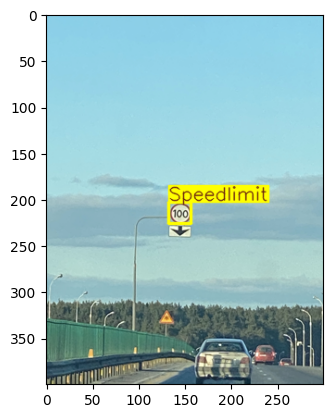

In [ ]:
test_img = cv2.imread(os.path.join(root_folder, test_img_list[6]))
img_src = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
results = model(test_img)
for result in results:
    annotator = Annotator(img_src)
    boxes = result.boxes
    for box in boxes:
        b = box.xyxy[0]  # get box coordinates in (top, left, bottom, right) format
        cls = box.cls
        annotator.box_label(b, model.names[int(cls)], color_dict[int(cls)])
print(model.names)
img_src = annotator.result()
plt.imshow(img_src)
plt.show()

In [ ]:
for idx , file in enumerate(test_img_list):
    test_img = cv2.imread(os.path.join(root_folder, file))
    img_src = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    results = model(test_img)

    for result in results:
        annotator = Annotator(img_src)
        boxes = result.boxes
        for box in boxes:
            b = box.xyxy[0]  # get box coordinates in (top, left, bottom, right) format
            cls = box.cls
            annotator.box_label(b, model.names[int(cls)], color_dict[int(cls)],color_dict_2[int(cls)])
    img_src = annotator.result()
    img_src = cv2.resize(img_src, (400,400))
    cv2.imwrite(os.path.join(result_folder, file), cv2.cvtColor(img_src, cv2.COLOR_RGB2BGR))


0: 480x640 2 Crosswalks, 10.7ms
Speed: 2.9ms preprocess, 10.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 1 Speedlimit, 10.3ms
Speed: 3.4ms preprocess, 10.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 1 Speedlimit, 9.7ms
Speed: 2.6ms preprocess, 9.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 1 Speedlimit, 9.8ms
Speed: 2.5ms preprocess, 9.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 1 Speedlimit, 11.1ms
Speed: 2.5ms preprocess, 11.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 2 Speedlimits, 10.4ms
Speed: 3.1ms preprocess, 10.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 1 Speedlimit, 9.8ms
Speed: 2.6ms preprocess, 9.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 1 Speedlimit, 10.9ms
Speed: 3.2ms preprocess, 10.9ms inference, 1.5ms postprocess p

### 5. TensorRT 변환
### 5-1. Export

* TODO : 위치 변경 (project_road_sign_detection 폴더로)
* TODO : 학습한 가중치 위치 `model_path`에 넣어주기

In [ ]:
cd /content/drive/MyDrive/Object_Detection/Road_Sign/project_road_sign_detection

/content/drive/MyDrive/Object_Detection/Road_Sign/project_road_sign_detection


In [ ]:
from ultralytics import YOLO

* TODO : engine 생성 후에 `best_fp32.engine`로 변경하기

In [ ]:
model_path = '/content/drive/MyDrive/Object_Detection/Road_Sign/project_road_sign_detection/runs/detect/road_sign_s2/weights/best.pt'
model = YOLO(model_path)
model.export(format='engine', device=0, half=False)

Ultralytics 8.3.143 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,932 parameters, 0 gradients, 6.3 GFLOPs

PyTorch: starting from '/content/drive/MyDrive/Object_Detection/Road_Sign/project_road_sign_detection/runs/detect/road_sign_s2/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 8, 8400) (5.2 MB)

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.53...
ONNX: export success ✅ 2.6s, saved as '/content/drive/MyDrive/Object_Detection/Road_Sign/project_road_sign_detection/runs/detect/road_sign_s2/weights/best.onnx' (10.1 MB)

TensorRT: starting export with TensorRT 10.11.0.33...
TensorRT: input "images" with shape(1, 3, 640, 640) DataType.FLOAT
TensorRT: output "output0" with shape(1, 8, 8400) DataType.FLOAT
TensorRT: building FP32 engine as /content/drive/MyDrive/Object_Detection/Road_Sign/project_road_sign_detection/runs/detect/road_sign_s2/weights/best.engine
Te

'/content/drive/MyDrive/Object_Detection/Road_Sign/project_road_sign_detection/runs/detect/road_sign_s2/weights/best.engine'

* TODO : engine 생성 후에 `best_fp16.engine`로 변경하기

In [ ]:
model_path = '/content/drive/MyDrive/Object_Detection/Road_Sign/project_road_sign_detection/yolo11n.pt'
model = YOLO(model_path)
model.export(format='engine', device=0, half=True)

### 5-2. 결과 비교하기

* TODO : 학습한 가중치 위치 `model_path`에 넣어주기
* TODO : fp16 engine경로 `model_fp16_path`에 넣어주기
* TODO : fp32 engine경로 `model_fp32_path`에 넣어주기

In [ ]:
from ultralytics import YOLO
import cv2
import os

root_folder = '/content/drive/MyDrive/Object_Detection/Road_Sign/road_sign_detection/val/images'
test_img_list = os.listdir(root_folder)

test_img = cv2.imread(os.path.join(root_folder, test_img_list[1]))
img_src = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

In [ ]:
# torch
model_path = '/content/drive/MyDrive/Object_Detection/Road_Sign/project_road_sign_detection/runs/detect/road_sign_s2/weights/best.pt'
model = YOLO(model_path)
results = model.val(data="road_sign.yaml", batch=1, imgsz=640, plots=False, device=0, half=False, verbose=False)
metric, speed = results.results_dict['metrics/mAP50-95(B)'], results.speed['inference']
print(metric, speed)

Ultralytics 8.3.143 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,932 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 117.0±28.5 MB/s, size: 257.0 KB)


val: Scanning /content/drive/MyDrive/Object_Detection/Road_Sign/road_sign_detection/val/labels.cache... 87 images, 1 backgrounds, 0 corrupt: 100%|██████████| 88/88 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 88/88 [00:02<00:00, 34.77it/s]

                   all         88        122      0.892      0.778      0.834      0.664
Speed: 0.8ms preprocess, 20.3ms inference, 0.0ms loss, 2.6ms postprocess per image


0.6644966780162476 20.3473364886122


In [ ]:
#float 16
model_fp16_path = '/content/drive/MyDrive/Object_Detection/Road_Sign/project_road_sign_detection/runs/detect/road_sign_s2/weights/best.engine'
model = YOLO(model_fp16_path)
results = model.val(data="road_sign.yaml", batch=1, imgsz=640, plots=False, device=0, half=True, verbose=False)
metric, speed = results.results_dict['metrics/mAP50-95(B)'], results.speed['inference']
print(metric, speed)

Ultralytics 8.3.143 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Loading /content/drive/MyDrive/Object_Detection/Road_Sign/project_road_sign_detection/runs/detect/road_sign_s2/weights/best.engine for TensorRT inference...
val: Fast image access ✅ (ping: 0.4±0.2 ms, read: 87.4±3.3 MB/s, size: 195.2 KB)


val: Scanning /content/drive/MyDrive/Object_Detection/Road_Sign/road_sign_detection/val/labels.cache... 87 images, 1 backgrounds, 0 corrupt: 100%|██████████| 88/88 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 88/88 [00:01<00:00, 54.63it/s]

                   all         88        122       0.85      0.833      0.865      0.669
Speed: 0.7ms preprocess, 7.2ms inference, 0.0ms loss, 2.8ms postprocess per image


0.6694620217253668 7.157795284125645


In [ ]:
#float 32
model_fp32_path =
model = YOLO(model_fp16_path)
results = model.val(data="road_sign.yaml", batch=1, imgsz=640, plots=False, device=0, half=False, verbose=False)
metric, speed = results.results_dict['metrics/mAP50-95(B)'], results.speed['inference']
print(metric, speed)

Ultralytics YOLOv8.0.180 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Loading runs/detect/road_sign_s/weights/best.engine for TensorRT inference...
100%|██████████| 755k/755k [00:00<00:00, 94.1MB/s]
val: Scanning /content/drive/MyDrive/0.dataset/road_sign/val/labels... 87 images, 0 backgrounds, 0 corrupt: 100%|██████████| 87/87 [02:18<00:00,  1.60s/it]
val: New cache created: /content/drive/MyDrive/0.dataset/road_sign/val/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 87/87 [00:05<00:00, 17.34it/s]
                   all         87        112      0.919      0.927      0.936      0.788
Speed: 0.4ms preprocess, 13.1ms inference, 0.0ms loss, 1.9ms postprocess per image


0.7881495053534824 13.124085020744937
